<a href="https://colab.research.google.com/github/kyulee-jeon/Tutorial/blob/main/Week11_ResNet_sj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Residual learning**

ResNet 은 'Skip connection'이라는 방법을 통해
Plain deep neural network에서 model이 복잡해지고, 
layer 구조가 깊어질수록 발생하는 vanishing gradient 및 over-fitting의 문제점을 해결하며, 
ILSVRC Challenge에서 사람보다 뛰어난 성능을 보였으며, 이후의 vision CNN 모델들에도 지속적으로 영향을 끼침

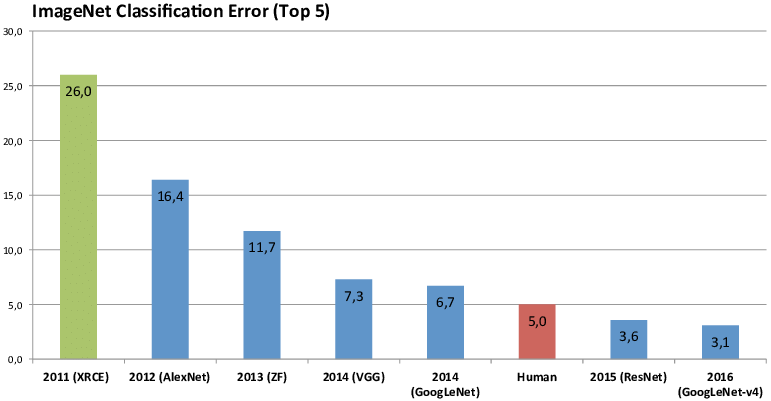

Residual block

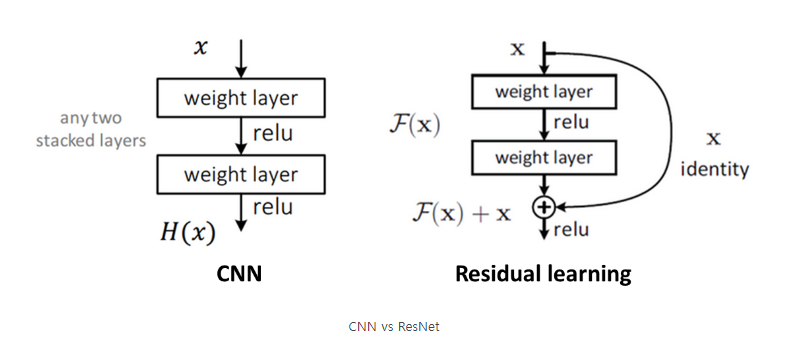

F(x) : weight layer => relu => weight layer 

x : identity

Ref: He et al., Deep Residual Learning for Image Recognition, 2015

-------------------
기존 네트워크는 layer의 출력 H(x)를 얻기 위한 학습을 함
ResNet은 F(x)=H(x)-x, 즉 잔차(residual)을 학습

이 방법을 통해 기존 네트워크들에서는 layer 수가 늘어나면 성능이 오히려 나빠졌는데, ResNet은 layer 수를 152~1000개까지 늘리면서도 성능을 높일 수 있었음.


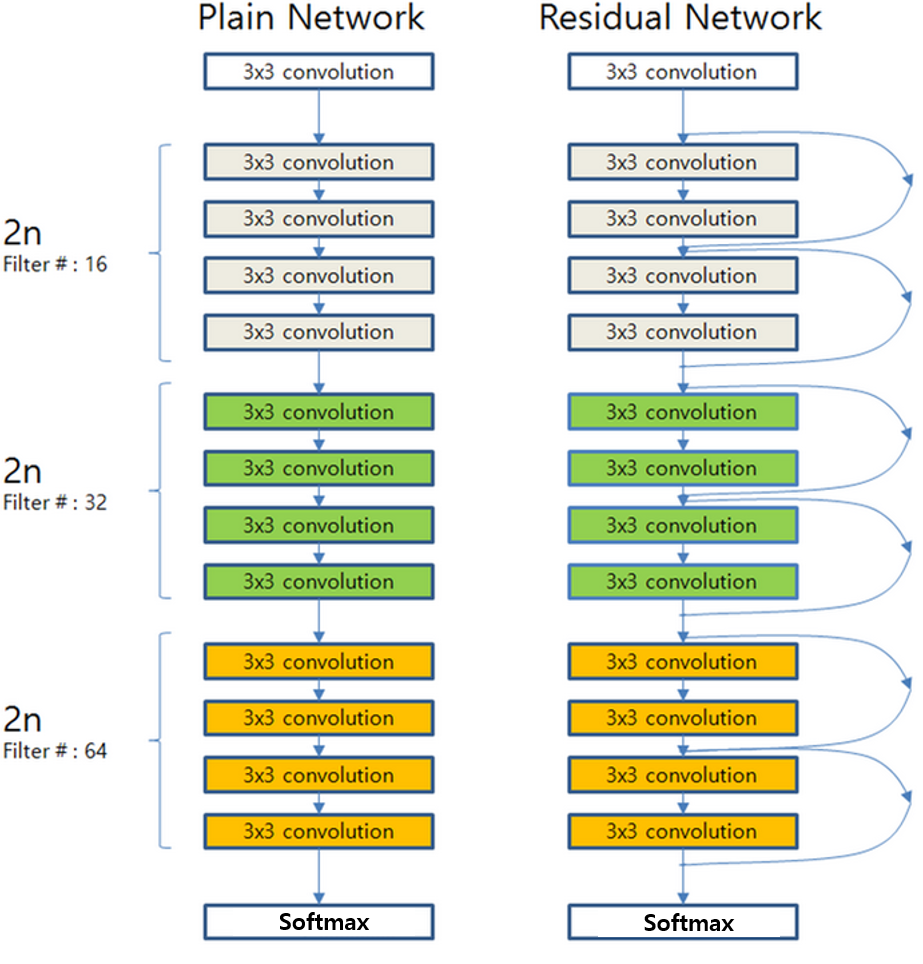

**Data Loading**

In [ ]:
#Connection to GoogleDrive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from glob import glob
import numpy as np
import pickle

In [ ]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/2022MedicalMachineLearning/data/COVID-19_Radiography_Dataset"
"""
#Define the file paths
all_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]
#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]
all_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]
# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths
"""


"\n#Define the file paths\nall_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]\n#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]\nall_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]\n# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths\n"

In [ ]:
#load the list
with open(os.path.join(data_path, "list_x_wk10"), "rb") as f:
  list_x = pickle.load(f)
with open(os.path.join(data_path, "list_y_wk10"), "rb") as f:
  list_y = pickle.load(f)

In [ ]:
#Gray scale to RGB
import cv2
list_x = list(map(lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB), list_x))

In [ ]:
#convert to ndarray of the data
data_x = np.array(list_x)
data_y = np.array(list_y)

In [ ]:
#save the array
'''
with open(os.path.join(data_path, "data_x_wk11"), "wb") as f:
  pickle.dump(data_x, f)
with open(os.path.join(data_path, "list_y_wk11"), "wb") as f:
  pickle.dump(data_y, f)
'''

In [ ]:
print("The length of list_x is {}".format(len(list_x)))
print("The length of list_y is {}".format(len(list_y)))
print("The shape of first element of list_x is {}".format(list_x[0].shape))

del list_x, list_y

The length of list_x is 8616
The length of list_y is 8616
The shape of first element of list_x is (299, 299, 3)


In [ ]:
# one hot encoding 
# 보통 다중 클래스 분류 문제에서 사용 (이번 실습은 binary classification)
# ex) {강아지, 고양이, 냉장고} --> 강아지=[1, 0, 0], 고양이=[0, 1, 0], 냉장고=[0, 0, 1]
# 꼭 실제값을 원-핫 벡터로 표현해야만 다중 클래스 분류 문제를 풀 수 있는 것은 아니지만, 
# 대부분의 다중 클래스 분류 문제가 각 클래스 간의 관계가 균등하다는 점에서 원-핫 벡터는 이러한 점을 표현할 수 있는 적절한 표현 방법
# ex) {Banana :1, Tomato :2, Apple :3, Strawberry :4, ... Watermelon :10} --> 이 정수 인코딩은 Banana가 Watermelon보다는 Tomato에 더 가깝다는 의미를 담고 있다.

data_y_ = data_y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(data_y_)
data_y = ohe.transform(data_y_)

**Data Preprocessing**

In [ ]:
import torch
from torchvision import transforms # 이미지 전처리 관련 라이브러리
from torch.utils.data import Dataset, DataLoader
from PIL import Image # 이미지 출력 관련 라이브러리

In [ ]:
# split into train, validation, and test sets (stratified)
#how to split validation and test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

random_seed = 11
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

from sklearn.model_selection import train_test_split
x_train, x_val_test, y_train, y_val_test = train_test_split(data_x, data_y, 
                                                            test_size = val_prop+test_prop, 
                                                            random_state = random_seed, 
                                                            stratify = data_y) # outcome에 대한 proportion이 비슷하도록

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = test_prop/(val_prop+test_prop),
                                                random_state = random_seed,
                                                stratify = y_val_test)

In [ ]:
#https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
#https://discuss.pytorch.org/t/apply-transform-on-numpy-arrays/19106/9
#https://wikidocs.net/157285
#https://stackoverflow.com/questions/46586616/pytorch-trying-to-apply-the-transform-to-a-numpy-array-fails-with-an-error
#https://076923.github.io/posts/Python-pytorch-11/

# numpy arrays 리스트를 pytorch dataset loader로 올리기 위한 함수를 정의
'''
PIL / numpy.ndarray  : 배열구조: "H x W x C"  픽셀 밝기 범위: [0~255]
Pytorch Image tensor : 배열구조: "C x H x W"  픽셀 밝기 범위: [0~1]
'''

class FromNPDataset(torch.utils.data.Dataset):  # Torch dataset 함수로 NP에서 tensor로 변환
  def __init__(self, x, y, transform = None): # parameter 설정
    self.x = x # image data
    self.y = y # label data
    self.transform = transform # image preprocessing 진행 여부
    
  def __getitem__(self, index): # data 불러오기 (batch size)
    x = self.x[index]
    y = self.y[index]
    
    if self.transform: # image preprocessing 진행 여부 설정에 따른 작업
      x = self.transform(x) # image transform 진행
    else: 
      x = torch.FloatTensor(x) # image → tensor로 변환

    y = torch.Tensor(y) # label → tensor로 변환
    
    return x, y

  def __len__(self): # 전체 data length 설정
    return len(self.y)

In [ ]:
#from torchvision.transforms.transforms import ToPILImage

#Statistics Based on ImageNet Data for Normalisation (입력 이미지 정규화)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
# 다음 시간에 ImageNet 데이터셋으로 훈련된 Resnet 모델을 사용해서 우리 데이터셋(covid)으로 transfer learning 예정
# ImageNet의 mean, std으로 미리 바꿔놓는 것

data_transforms = {'train':transforms.Compose([ 
    
                                transforms.ToPILImage(),
                                    # Pytorch Image Tensor → PIL 이미지, Numpy 배열
                                        #  - 배열구조: "C(channel,채널) x H(height,높이) x W(width,너비)" → "H x W x C"
                                        #  - 이미지 픽셀 밝기 정도(scale): [0~1] → [0~255]

                                transforms.RandomRotation(15), # Rotates the images upto Max of 15 Degrees
                                    # RandomRotation
                                        #  - Train 데이터의 다양성을 높여 Model 성능의 overfitting을 막고 generalizability를 높임
                                        #  - Validation, Test 데이터는 실제 데이터 반영을 위해 진행하지 않음
                                # transforms.Resize((150,150)), #Resizes all images into same dimension
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150        
                                # transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 

                                transforms.ToTensor(), # Coverts into Tensors

                                transforms.Normalize(mean = mean_nums, std=std_nums)]), 
                                      # Normalizes
                                        # - Resnet은 ImageNet으로부터 훈련됨
                                        # - 추후 Transfer learning을 위해 ImageNet의 통계값과 일치하도록 변경

                    'val': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ]),
                    'test': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ])
                    }


In [ ]:
#Prepare torch dataset

#ds_train = FromNPDataset(x_train, y_train, transform = None)
#ds_val = FromNPDataset(x_val, y_val, transform = None)
#ds_test = FromNPDataset(x_test, y_test, transform = None)

ds_train = FromNPDataset(x_train, y_train, transform = data_transforms['train'])
ds_val = FromNPDataset(x_val, y_val, transform = data_transforms['val'])
ds_test = FromNPDataset(x_test, y_test, transform = data_transforms['test'])

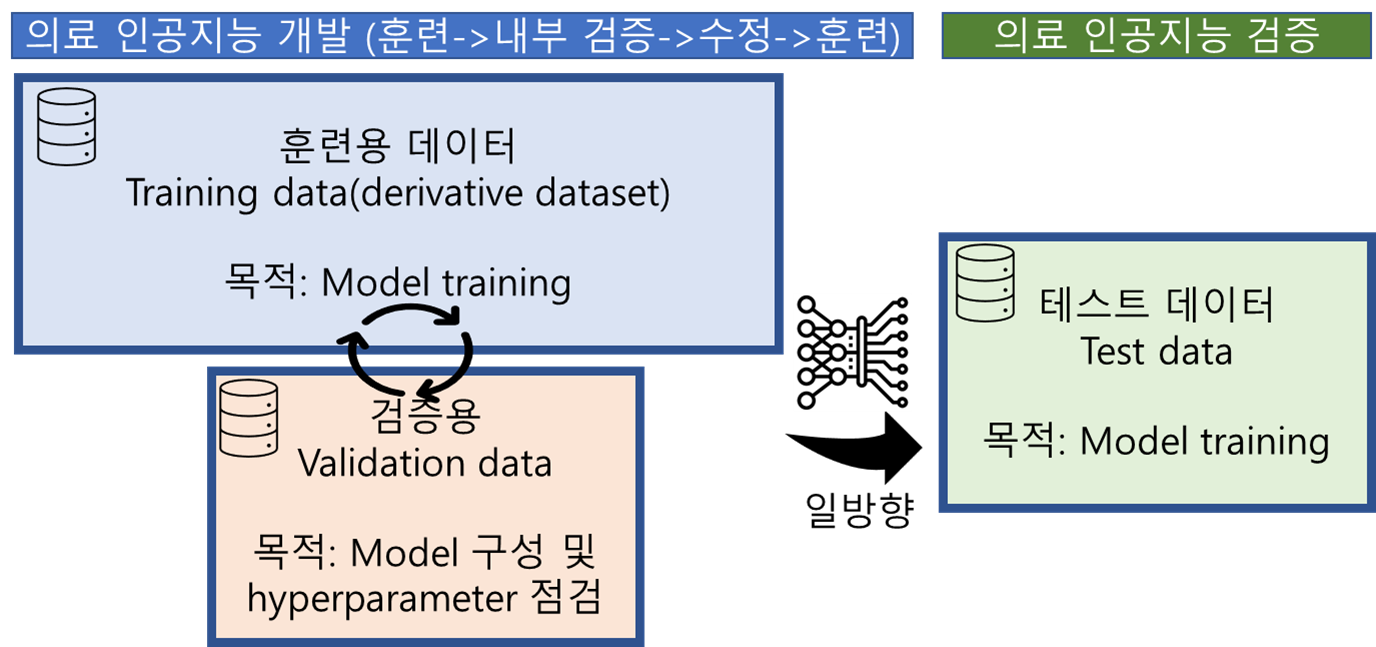

# **Defining the model**

In [ ]:
import torchvision.models as models

In [ ]:
# GPU 장치 사용 설정
use_cuda = torch.cuda.is_available() 
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
output_dim = 2
intput_channel = 3
input_dim = 299*299*3

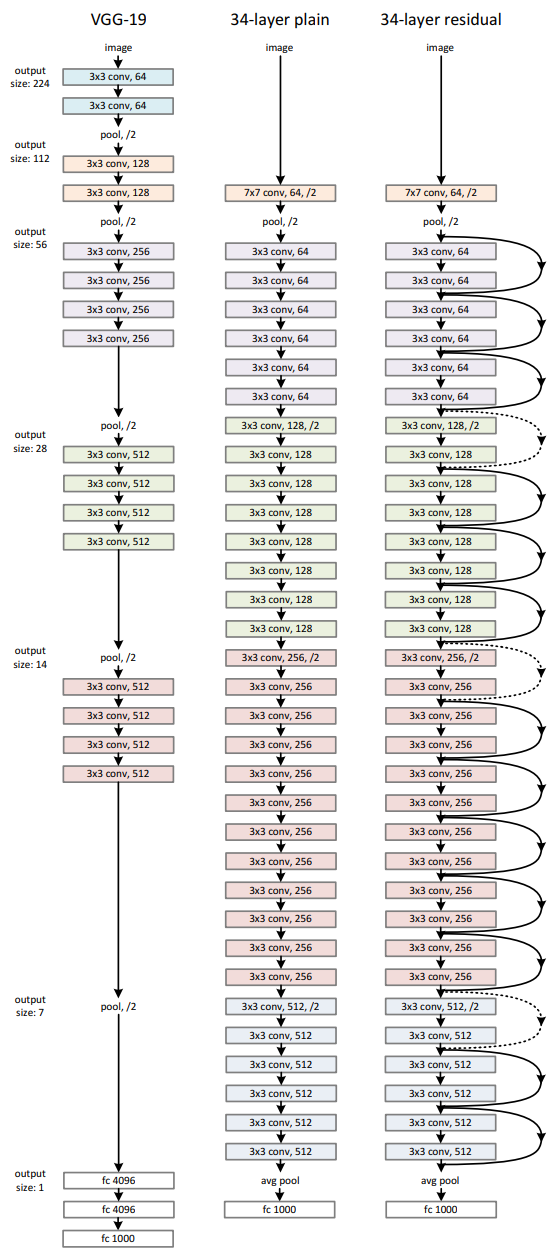

34-layer residual에서 실선: dimension 변화x 점선: dimension 변화o

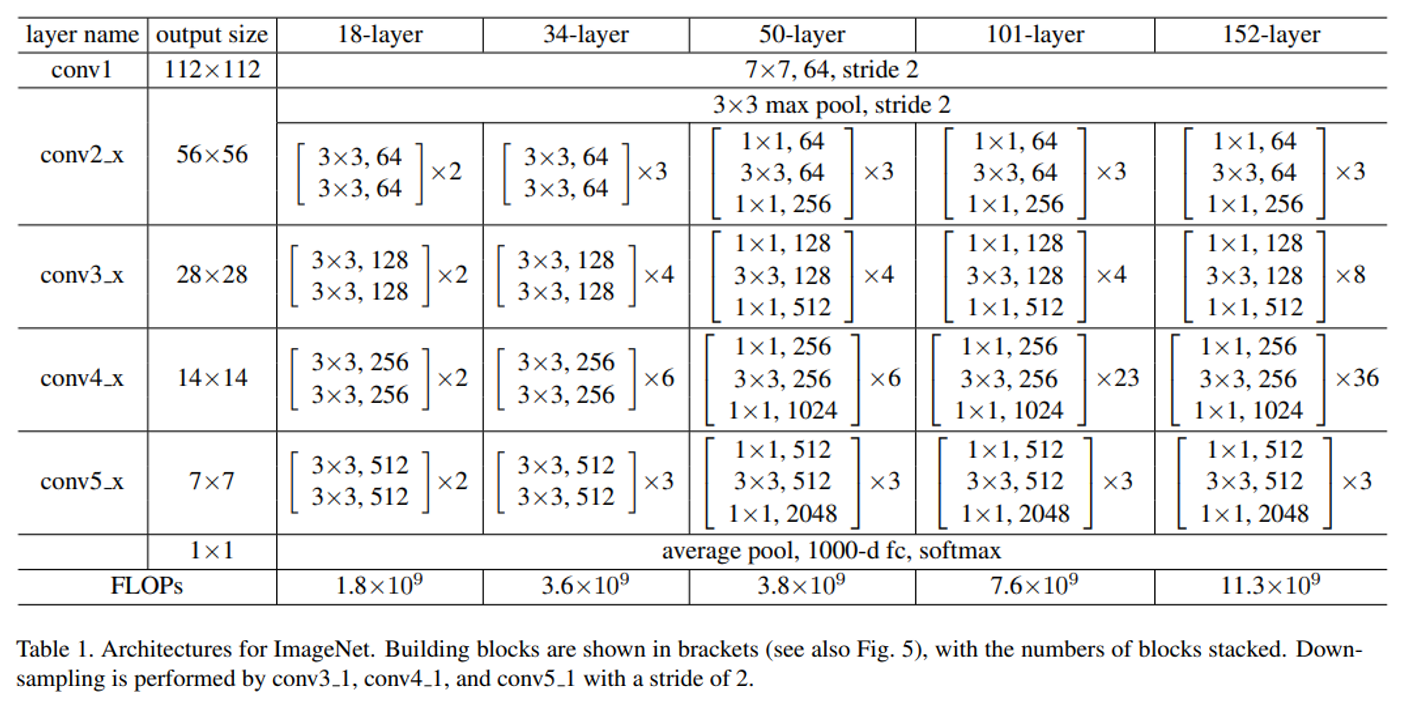

In [ ]:
from torch import nn
import torch.nn.functional as F

# ResNet 모델은 layer가 2개씩 있는 BasicBlock들이 쌓인 것 + shortcut connection
# ex) ResNet18: BasicBlock [2,2,2,2] (총 16개 convLayer)

class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride = 1): # stride = 1 ---> Identity mapping
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channel, out_channel, 
                           kernel_size = 3, # 3x3 필터를 사용 (=ResNet 논문)
                           stride = stride, # default=1; Dimension을 줄이기 위해서 stride 값 조절 (stride=2→output dimension이 1/2 감소)
                           padding =1, # padding을 1만큼 주기 때문에 너비와 높이가 동일함
                           bias = False) # BatchNorm에서 Bias가 있으므로 False로 놨다고 함(ResNet 저자)
    self.bn1 = nn.BatchNorm2d(out_channel)

    self.conv2 = nn.Conv2d(out_channel, out_channel, 
                           kernel_size = 3, 
                           stride = 1, 
                           padding =1, 
                           bias = False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    
    self.shortcut = nn.Sequential() # 여러개의 layer를 차례로 연결하기 
    if stride != 1 or in_channel != out_channel: 
      # stride가 1이 아니거나 in_channel과 out_channel이 다른 경우
      # = Identity mapping이 아닌 경우 (입력값과 출력값의 차원이 다르다는 뜻)
      # 해당 stride 값을 x에 적용, 차원을 맞춰서 skip connection 되도록 한다.
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias = False),
          nn.BatchNorm2d(out_channel)
      )
    
  def forward(self, x):
    out = self.conv1(x) # convolution 1
    out = self.bn1(out) # batch normaliztion
    out = F.relu(out)   # relu
    out = self.conv2(out) # convolution 2
    out = self.bn2(out)   # batch normaliztion 
    out += self.shortcut(x) # Skip connection
    out = F.relu(out)       # relu
    return out

In [ ]:
# _make_layer 함수를 통해 BasicBlock 생성

class ResNet(nn.Module):
  def __init__(self, num_classes = 2): # covid, normal
    super(ResNet, self).__init__()

    self.conv0 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 8, stride = 1) # zero-convolution layer 통과
    self.in_channel = 16    
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding =1, bias = False)

    self.bn1    = nn.BatchNorm2d(16) # in_channel
    self.layer1 = self._make_layer(out_channel=16, num_blocks=2, stride=1) # ※num_blocks: skip connection 사이 블럭 수
    self.layer2 = self._make_layer(out_channel=32, num_blocks=2, stride=2) # 채널(필터) 개수가 늘어날 때 마다 stride=2(→차원 줄어들도록) 
    self.layer3 = self._make_layer(out_channel=64, num_blocks=2, stride=2)
    self.linear = nn.Linear(64, num_classes) # Fully connected layer

  def _make_layer(self, out_channel, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1) 
              # 더하기 기호가 아닌, 리스트에 원소 추가
              # stride 값이 맨 처음 convLayer에만 적용되도록 하고(=너비,높이 줄어들도록) 
              # 이후부터는 stride=1이 되도록(=dim변화 없도록) ※ 모델 그림 참고
              # layer1=[1], layer2=[2,1], layer3=[2,1]
              # 예) stride가 5인 layer=[5,1,1,1,1]

    layers = [] # 빈 layer 리스트 준비

    for stride in strides: # stride 리스트 안에 있는 원소 개수만큼 = basicBlock 개수만큼
      layers.append(BasicBlock(self.in_channel, out_channel, stride))
      self.in_channel = out_channel # 예) 16→32, stride=5 일때, [16,32,32,32,32]
    return nn.Sequential(*layers) # layer들을 sequential하게 펼쳐서 넣겠다는 뜻                                   

  def forward(self, x):
    x = self.conv0(x)  #299*299*3 -> #292*292*3 (dimension 조정)
    x = F.max_pool2d(x, 8) # 36*36*3
    x = F.relu(x)

    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.layer1(out) # basicBlock 2개씩
    out = self.layer2(out)
    out = self.layer3(out)

    out = F.avg_pool2d(out, 8) # Average pooling, Fully connected layer
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
"""
W = 299 #no. of dimension
K = 5 #kernel
P = 0 #padding
S = 1 #stride
M = 2 max pooling

W = ((W - K + 2*P)/S)+1
W = W/M #after max pooling
"""

'\nW = 299 #no. of dimension\nK = 5 #kernel\nP = 0 #padding\nS = 1 #stride\nM = 2 max pooling\n\nW = ((W - K + 2*P)/S)+1\nW = W/M #after max pooling\n'

In [ ]:
model = ResNet().to(device) # 사용 중인 device(gpu/cpu)에 모델 넣기

In [ ]:
print(model)

ResNet(
  (conv0): Conv2d(3, 3, kernel_size=(8, 8), stride=(1, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 292, 292]             579
            Conv2d-2           [-1, 16, 36, 36]             432
       BatchNorm2d-3           [-1, 16, 36, 36]              32
            Conv2d-4           [-1, 16, 36, 36]           2,304
       BatchNorm2d-5           [-1, 16, 36, 36]              32
            Conv2d-6           [-1, 16, 36, 36]           2,304
       BatchNorm2d-7           [-1, 16, 36, 36]              32
        BasicBlock-8           [-1, 16, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]           2,304
      BatchNorm2d-10           [-1, 16, 36, 36]              32
           Conv2d-11           [-1, 16, 36, 36]           2,304
      BatchNorm2d-12           [-1, 16, 36, 36]              32
       BasicBlock-13           [-1, 16, 36, 36]               0
           Conv2d-14           [-1, 32,

모델구조
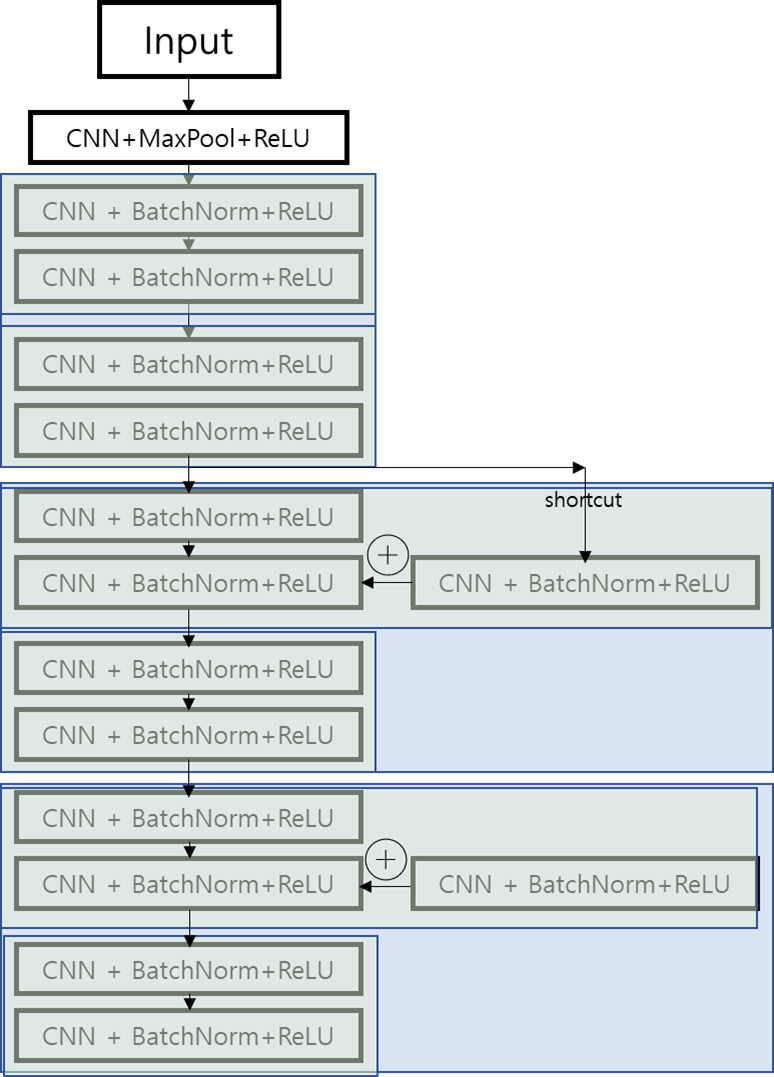

# **Configuration of Training**

In [ ]:
batch_size = 128
epochs = 30 # 보통 100. 시간 상 줄임
learning_rate = 0.01

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), 
                            lr = learning_rate,
                            weight_decay = 0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, 
                                            gamma = 0.1) # step size마다 learning rate를 0.1로 줄이겠다.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset = ds_train,
    batch_size = batch_size,
    shuffle = True
)
val_loader = torch.utils.data.DataLoader(
    dataset = ds_val,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = ds_test,
    batch_size = batch_size,
    shuffle = True
)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send the data to device
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum of all loss values
            loss += F.cross_entropy(output, target,reduction='sum').item()
            
            # the class with the maximal value is the predicted value
            pred = output.max(1, keepdim=True)[1]
            target_label = target.max(1, keepdim=True)[1]
            correct += (target_label==pred).sum().item()
            
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    return loss, accuracy

# **Fitting the model**

In [ ]:
val_loss_ = []
val_accuracy_ = []
for epoch in range(epochs):
  scheduler.step()
  train(model, train_loader, optimizer)
  val_loss, val_accuracy = evaluate(model, val_loader)
  val_loss_.append(val_loss)
  val_accuracy_.append(val_accuracy)

  print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'. format(epoch, val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[0] Validation Loss: 0.6515, Accuracy: 67.38%
[1] Validation Loss: 0.6202, Accuracy: 67.32%
[2] Validation Loss: 0.6211, Accuracy: 67.38%
[3] Validation Loss: 0.6173, Accuracy: 72.95%
[4] Validation Loss: 0.4640, Accuracy: 78.76%
[5] Validation Loss: 0.5136, Accuracy: 79.05%
[6] Validation Loss: 0.3694, Accuracy: 83.05%
[7] Validation Loss: 0.5833, Accuracy: 72.14%
[8] Validation Loss: 0.5852, Accuracy: 70.75%
[9] Validation Loss: 0.4036, Accuracy: 80.96%
[10] Validation Loss: 0.6051, Accuracy: 76.32%
[11] Validation Loss: 0.4747, Accuracy: 78.53%
[12] Validation Loss: 0.3696, Accuracy: 84.39%
[13] Validation Loss: 0.5331, Accuracy: 73.65%
[14] Validation Loss: 0.3921, Accuracy: 83.58%
[15] Validation Loss: 0.3642, Accuracy: 85.55%
[16] Validation Loss: 0.3730, Accuracy: 83.98%
[17] Validation Loss: 0.5056, Accuracy: 78.87%
[18] Validation Loss: 0.2988, Accuracy: 88.10%
[19] Validation Loss: 0.6686, Accuracy: 71.50%
[20] Validation Loss: 0.9711, Accuracy: 76.26%
[21] Validation Loss: 0

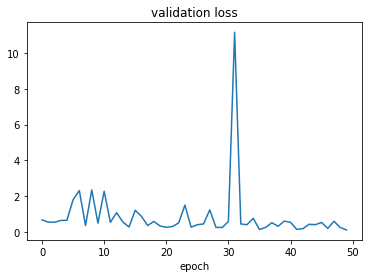

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_loss_)
plt.title("validation loss")
plt.xlabel("epoch")
plt.show()

※ Epoch 100 으로 실행했을 때 결과

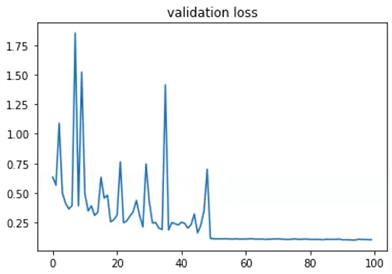

In [ ]:
torch.save(model.state_dict(), os.path.join(data_path, "wk11_my_ResNet.pth"))

NameError: ignored

In [ ]:
model.load_state_dict(torch.load(os.path.join(data_path, "wk11_my_ResNet.pth")))

<All keys matched successfully>

In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader)
print('Performance of my ResNet \n Test Loss: {:.4f}, Accuracy: {:.2f}%'. format(test_loss, test_accuracy))

Performance of my ResNet 
 Test Loss: 0.0849, Accuracy: 96.69%


Summary


*   Residual learning이 vanishing gradient(layer가 깊어짐에 따라 소실되는 features)를 줄이고, 모델의 over-fitting을 줄여준다.
*   최근 등장한 Transformer 전까지는 SOTA 모델이었음
* 다음 시간 Transfer learning: SOTA 모델을 Transfer learning 하는 것보다 더 좋은 성능의 모델을 '새롭게' 만들기는 쉽지 않다.
* 임상 연구에서는 주로 transfer learning 사용

